In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

from torchvision.models.resnet import BasicBlock

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

from tqdm import tqdm
import pickle as pk
import os
import glob

import matplotlib.pyplot as plt

from structures import LateralInhibition, LIBlock


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using {device}")

using cuda


## Load and normalize ImageNet

In [2]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

TRAIN_NORMALIZE = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN.tolist(), std=IMAGENET_STD.tolist()),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.08, 1.0), ratio=(0.75, 1.33)),
    ]
)

TEST_NORMALIZE = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN.tolist(), std=IMAGENET_STD.tolist()),
    ]
)

def deprocess(img):
    transform = transforms.Compose(
        [
            transforms.Normalize(mean=[0, 0, 0], std=(1.0 / IMAGENET_STD).tolist()),
            transforms.Normalize(mean=(-IMAGENET_MEAN).tolist(), std=[1, 1, 1]),
            transforms.ToPILImage(),
        ]
    )
    return transform(img)


def load_datas(batch_size=128):
    train_dataset = ImageFolder(root="imagenet-mini/train", transform=TRAIN_NORMALIZE)
    test_dataset = ImageFolder(root="imagenet-mini/val", transform=TEST_NORMALIZE)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=8, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=8, shuffle=True)

    return train_loader, test_loader

train_loader, test_loader = load_datas()
TRAIN_SIZE, TEST_SIZE = len(train_loader.dataset), len(test_loader.dataset)

print(f"train dataset: {TRAIN_SIZE}, test_dataset: {TEST_SIZE}")

train dataset: 34745, test_dataset: 3923


## Utils

In [21]:
def train_model(model, max_epochs=10, batch_accumulation=2, eval_freq=2, comment="", verbose=True):
    writer = SummaryWriter(comment=comment)

    # Create log dir
    log_path = "logs/"
    model_name = type(model).__name__

    max_run_id = 0
    for path in glob.glob(os.path.join(log_path, model_name + "_[0-9]*")):
        file_name = os.path.basename(path)
        ext = file_name.split("_")[-1]
        if (
            model_name == "_".join(file_name.split("_")[:-1])
            and ext.isdigit()
            and int(ext) > max_run_id
        ):
            max_run_id = int(ext)

    file_name = model_name + f"_{max_run_id+1}"
    save_dir = os.path.join(log_path, file_name)
    os.mkdir(save_dir)

    train_loss_record = []
    train_accuracy_record = []
    test_loss_record = []
    test_accuracy_record = []

    # Setup training
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4
    )
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    # Train
    for epoch in range(max_epochs):
        total_loss, correct = 0, 0

        for batch_idx, (images, labels) in enumerate(tqdm(train_loader)):
            images, labels = images.to(device), labels.to(device)

            output = model(images)
            pred = output.argmax(dim=1)

            loss = criterion(output, labels) / batch_accumulation
            total_loss += loss

            correct += torch.sum(labels == pred).sum().item()

            loss.backward()

            if (batch_idx + 1) % batch_accumulation:
                optimizer.step()
                optimizer.zero_grad()

        if scheduler:
            scheduler.step()

        total_loss /= TRAIN_SIZE
        accuracy = correct / TRAIN_SIZE

        writer.add_scalar("Train/loss", total_loss, epoch)
        writer.add_scalar("Train/accuracy", accuracy, epoch)

        train_loss_record.append(total_loss.item())
        train_accuracy_record.append(accuracy)

        if verbose:
            print(f"[{epoch + 1:2d}/{max_epochs}] loss_train: {total_loss:.2E} accuracy_train: {accuracy:.2%}")

        if not epoch % eval_freq:
            continue

        with torch.no_grad():
            test_loss, correct = 0, 0

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                output = model(images)
                pred = output.argmax(dim=1)

                loss = criterion(output, labels)
                test_loss += loss

                correct += torch.sum(labels == pred).sum().item()

            test_loss /= TEST_SIZE
            accuracy = correct / TEST_SIZE

            writer.add_scalar("Test/loss", test_loss, epoch)
            writer.add_scalar("Test/accuracy", accuracy, epoch)

            test_loss_record.append(test_loss.item())
            test_accuracy_record.append(accuracy)

        if verbose:
            print(f"loss_test: {total_loss:.2E} accuracy_test: {accuracy:.2%}")

        if verbose and hasattr(model, "log"):
            W = torch.concatenate([t.flatten() for t in model.log["W"]])
            m = torch.tensor([t.item() for t in model.log["m"]])
            v = torch.tensor([t.item() for t in model.log["v"]])
            b = torch.tensor([t.item() for t in model.log["b"]])

            print("LI-layers params (avg, min, max):")
            print(f"* W: ({W.mean():.2f}, {W.min():.2f}, {W.max():.2f})")
            print(f"* m: ({m.mean():.2f}, {m.min():.2f}, {b.max():.2f})")
            print(f"* v: ({v.mean():.2f}, {v.min():.2f}, {v.max():.2f})")
            print(f"* b: ({b.mean():.2f}, {b.min():.2f}, {b.max():.2f})")

    # saving logs
    log = {
        "train_loss": train_loss_record,
        "train_accuracy": train_accuracy_record,
        "test_loss": test_loss_record,
        "test_accuracy": test_accuracy_record,
    }

    with open(os.path.join(save_dir, "log.pkl"), "wb") as f:
        pk.dump(log, f)

    torch.save(model, os.path.join(save_dir, "model.pth"))


def evaluate(model, data_loader, mode="train"):
    correct = 0
    for _, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)
        pred = torch.argmax(model(images), dim=1)
        correct += torch.sum(labels == pred).sum().item()

    print(f"{mode} accuracy: {correct / len(data_loader.dataset):.2%}")


def plot_weights_heatmap(model):
    assert hasattr(model, "log")

    weights = [t.flatten().detach().cpu() for t in alexnetLI.log["W"]]

    w_min = torch.concatenate(weights).min()
    w_max = torch.concatenate(weights).max()

    bins = np.linspace(w_min, w_max, 20)
    counts = np.zeros((len(weights), len(bins) - 1))

    # Compter les valeurs dans chaque plage pour chaque tensor
    for i, W in enumerate(weights):
        for j in range(len(bins) - 1):
            counts[i][j] = ((W >= bins[j]) & (W < bins[j + 1])).sum().item()

    counts /= counts.sum(axis=1).reshape(-1, 1)

    fig, ax = plt.subplots()

    labels = [r"$LI_{}$".format(i + 1) for i in range(counts.shape[0])]
    xticks = [f"{bins[i] + bins[i+1] / 2:.2f}" for i in range(bins.size - 1)]

    ax.imshow(counts, cmap="Blues", interpolation="nearest")
    ax.set_xticks(np.arange(counts.shape[1]), xticks, rotation=45)
    ax.set_yticks(np.arange(counts.shape[0]), labels)

    plt.tight_layout()
    plt.show()

    # colors = ["Reds", "Blues", "Greens", "Oranges", "Purples"]

    # fig, axes = plt.subplots(5, 1, figsize=(8,2), sharex=True)

    # for i, ax in enumerate(axes):
    #     ax.imshow(counts[i].reshape(1, -1), cmap=colors[i], vmin=w_min, vmax=w_max)
    #     ax.set_ylabel(r"$LI_{}$".format(i+1))
    #     ax.set_yticks([])
    #     ax.set_aspect('equal')

    # xticks = [f"{bins[i] + bins[i+1] / 2:.2f}" for i in range(bins.size - 1)]
    # ax.set_xticks(np.arange(counts.shape[1]), xticks, rotation=45)

    # fig.subplots_adjust(wspace=0, hspace=0)
    # plt.show()


## AlexNet

In [5]:
train_loader, test_loader = load_datas(batch_size=128)

### Baseline

In [6]:
alexnet = models.alexnet(weights="DEFAULT").to(device)
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [28]:
evaluate(alexnet, train_loader, mode="train")

train accuracy: 53.05%


In [48]:
evaluate(alexnet, test_loader, mode="test")

test accuracy: 52.23%


In [13]:
alexnet = models.alexnet(weights="DEFAULT").to(device)
train_model(alexnet, 10, 2, 2, f"ALEXNET")

100%|██████████| 272/272 [00:32<00:00,  8.30it/s]


[ 1/10] loss_train: 1.15E-02 accuracy_train: 37.27%


100%|██████████| 272/272 [00:32<00:00,  8.30it/s]

[ 2/10] loss_train: 1.01E-02 accuracy_train: 42.92%


loss_test: 1.01E-02 accuracy_test: 37.45%


100%|██████████| 272/272 [00:31<00:00,  8.69it/s]


[ 3/10] loss_train: 9.50E-03 accuracy_train: 45.72%


100%|██████████| 272/272 [00:32<00:00,  8.25it/s]

[ 4/10] loss_train: 8.76E-03 accuracy_train: 49.15%


loss_test: 8.76E-03 accuracy_test: 34.92%


100%|██████████| 272/272 [00:32<00:00,  8.47it/s]


[ 5/10] loss_train: 8.18E-03 accuracy_train: 51.58%


100%|██████████| 272/272 [00:32<00:00,  8.38it/s]

[ 6/10] loss_train: 7.78E-03 accuracy_train: 53.63%


loss_test: 7.78E-03 accuracy_test: 33.34%


100%|██████████| 272/272 [00:32<00:00,  8.35it/s]


[ 7/10] loss_train: 7.37E-03 accuracy_train: 55.69%


100%|██████████| 272/272 [00:32<00:00,  8.33it/s]

[ 8/10] loss_train: 7.14E-03 accuracy_train: 57.23%


loss_test: 7.14E-03 accuracy_test: 32.32%


100%|██████████| 272/272 [00:33<00:00,  8.19it/s]


[ 9/10] loss_train: 6.68E-03 accuracy_train: 59.71%


100%|██████████| 272/272 [00:32<00:00,  8.37it/s]

[10/10] loss_train: 6.57E-03 accuracy_train: 60.54%


loss_test: 6.57E-03 accuracy_test: 31.68%


### Alexnet+LI

In [10]:
class AlexnetLI(nn.Module):
    def __init__(self, weights="DEFAULT", li_weights="zeros", freeze=False):
        super(AlexnetLI, self).__init__()

        alexnet = models.alexnet(weights=weights)

        if freeze:
            for param in alexnet.parameters():
                param.require_grad = False

        self.log = {"W": [], "m": [], "v": [], "b": []}

        # Rebuild alexnet features, by adding a LI layer after each convolutions'
        # activation function
        features = list(alexnet.features.children())
        new_features = []

        for i, l in enumerate(features):
            new_features.append(l)
            if isinstance(l, nn.ReLU):
                li = LateralInhibition(features[i - 1].out_channels, weights=li_weights)
                new_features.append(li)
                self.log["W"].append(li.weights)
                self.log["m"].append(li.m)
                self.log["v"].append(li.v)
                self.log["b"].append(li.b)

        self.features = nn.Sequential(*new_features)

        # Copy all the non-convolutional parts of AlexNet
        self.avg_pool = alexnet.avgpool
        self.classifier = alexnet.classifier

    def forward(self, x):
        x = self.features(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [22]:
alexnetLI = AlexnetLI().to(device) 
train_model(alexnetLI, 10, 2, 2, f"ALEXNET_LI 256 log")

100%|██████████| 272/272 [00:45<00:00,  6.03it/s]


[ 1/10] loss_train: 1.13E-02 accuracy_train: 37.83%


100%|██████████| 272/272 [00:44<00:00,  6.09it/s]

[ 2/10] loss_train: 1.01E-02 accuracy_train: 43.17%


loss_test: 1.01E-02 accuracy_test: 37.04%
LI-layers params (avg, min, max):
* W: (0.00, -0.02, 0.13)
* m: (-0.08, -0.17, -0.05)
* v: (0.95, 0.74, 1.09)
* b: (-0.09, -0.17, -0.05)


100%|██████████| 272/272 [00:44<00:00,  6.05it/s]


[ 3/10] loss_train: 9.24E-03 accuracy_train: 46.75%


100%|██████████| 272/272 [00:44<00:00,  6.08it/s]

[ 4/10] loss_train: 8.54E-03 accuracy_train: 50.14%


loss_test: 8.54E-03 accuracy_test: 34.41%
LI-layers params (avg, min, max):
* W: (0.00, -0.02, 0.18)
* m: (-0.12, -0.23, -0.09)
* v: (0.96, 0.63, 1.17)
* b: (-0.14, -0.23, -0.09)


100%|██████████| 272/272 [00:45<00:00,  6.04it/s]


[ 5/10] loss_train: 8.06E-03 accuracy_train: 52.63%


100%|██████████| 272/272 [00:45<00:00,  6.04it/s]

[ 6/10] loss_train: 7.55E-03 accuracy_train: 55.43%


loss_test: 7.55E-03 accuracy_test: 33.55%
LI-layers params (avg, min, max):
* W: (0.00, -0.03, 0.22)
* m: (-0.14, -0.29, -0.13)
* v: (0.99, 0.58, 1.26)
* b: (-0.17, -0.28, -0.13)


100%|██████████| 272/272 [00:44<00:00,  6.05it/s]


[ 7/10] loss_train: 7.12E-03 accuracy_train: 57.48%


100%|██████████| 272/272 [00:44<00:00,  6.05it/s]

[ 8/10] loss_train: 6.76E-03 accuracy_train: 59.53%


loss_test: 6.76E-03 accuracy_test: 32.27%
LI-layers params (avg, min, max):
* W: (0.00, -0.04, 0.24)
* m: (-0.16, -0.34, -0.12)
* v: (0.99, 0.55, 1.29)
* b: (-0.18, -0.32, -0.12)


100%|██████████| 272/272 [00:44<00:00,  6.05it/s]


[ 9/10] loss_train: 6.43E-03 accuracy_train: 61.14%


100%|██████████| 272/272 [00:45<00:00,  6.04it/s]

[10/10] loss_train: 6.10E-03 accuracy_train: 62.93%


loss_test: 6.10E-03 accuracy_test: 32.07%
LI-layers params (avg, min, max):
* W: (0.00, -0.05, 0.26)
* m: (-0.18, -0.36, -0.15)
* v: (0.99, 0.56, 1.32)
* b: (-0.21, -0.34, -0.15)


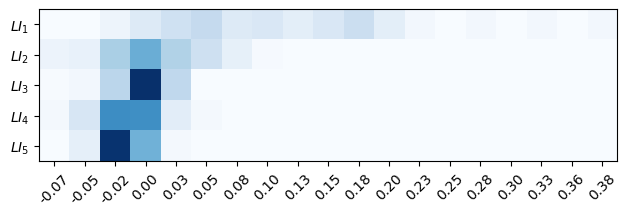

In [26]:
model = torch.load("logs/AlexnetLI_3/model.pth")
plot_weights_heatmap(model)

### Alexnet+BatchNorm

In [24]:
class AlexnetBatchNorm(nn.Module):
    def __init__(self, weights="DEFAULT"):
        super(AlexnetBatchNorm, self).__init__()

        alexnet = models.alexnet(weights=weights)

        # Rebuild alexnet features, by adding a BatchNorm layer after each convolutions'
        # activation function
        features = list(alexnet.features.children())
        new_features = []

        for i, l in enumerate(features):
            new_features.append(l)
            if isinstance(l, nn.ReLU):
                new_features.append(nn.BatchNorm2d(features[i-1].out_channels))

        self.features = nn.Sequential(*new_features)

        # Copy all the non-convolutional parts of AlexNet
        self.avg_pool = alexnet.avgpool
        self.classifier = alexnet.classifier

    def forward(self, x):
        x = self.features(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [28]:
alexnetBN = AlexnetBatchNorm().to(device)
train_model(alexnetBN, 10, 2, 2, "ALEXNET_BatchNorm 256")

100%|██████████| 272/272 [00:39<00:00,  6.92it/s]


[ 1/10] loss_train: 1.28E-02 accuracy_train: 32.65%


100%|██████████| 272/272 [00:36<00:00,  7.40it/s]

[ 2/10] loss_train: 1.03E-02 accuracy_train: 42.07%


loss_test: 1.03E-02 accuracy_test: 35.15%


100%|██████████| 272/272 [00:37<00:00,  7.23it/s]


[ 3/10] loss_train: 9.16E-03 accuracy_train: 47.54%


100%|██████████| 272/272 [00:34<00:00,  8.00it/s]

[ 4/10] loss_train: 8.37E-03 accuracy_train: 51.39%


loss_test: 8.37E-03 accuracy_test: 34.49%


100%|██████████| 272/272 [00:35<00:00,  7.73it/s]


[ 5/10] loss_train: 7.65E-03 accuracy_train: 54.78%


100%|██████████| 272/272 [00:34<00:00,  7.79it/s]

[ 6/10] loss_train: 7.15E-03 accuracy_train: 57.26%


loss_test: 7.15E-03 accuracy_test: 34.72%


100%|██████████| 272/272 [00:35<00:00,  7.72it/s]


[ 7/10] loss_train: 6.74E-03 accuracy_train: 59.41%


100%|██████████| 272/272 [00:34<00:00,  7.79it/s]

[ 8/10] loss_train: 6.39E-03 accuracy_train: 61.51%


loss_test: 6.39E-03 accuracy_test: 33.32%


100%|██████████| 272/272 [00:35<00:00,  7.63it/s]


[ 9/10] loss_train: 5.97E-03 accuracy_train: 64.01%


100%|██████████| 272/272 [00:35<00:00,  7.65it/s]

[10/10] loss_train: 5.77E-03 accuracy_train: 65.23%


loss_test: 5.77E-03 accuracy_test: 32.09%


### Alexnet+GroupNorm

In [26]:
class AlexnetGroupNorm(nn.Module):
    def __init__(self, weights="DEFAULT"):
        super(AlexnetGroupNorm, self).__init__()

        alexnet = models.alexnet(weights=weights)

        # Rebuild alexnet features, by adding a LayerNorm layer after each convolutions'
        # activation function
        features = list(alexnet.features.children())
        new_features = []
        
        for i, l in enumerate(features):
            new_features.append(l)
            if isinstance(l, nn.ReLU):
                new_features.append(nn.GroupNorm(1, features[i-1].out_channels))

        self.features = nn.Sequential(*new_features)

        # Copy all the non-convolutional parts of AlexNet
        self.avg_pool = alexnet.avgpool
        self.classifier = alexnet.classifier

    def forward(self, x):
        x = self.features(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [29]:
alexnetGN = AlexnetGroupNorm().to(device)
train_model(alexnetGN, 10, 2, 2, "ALEXNET_GroupNorm 256")

100%|██████████| 272/272 [00:40<00:00,  6.70it/s]


[ 1/10] loss_train: 1.29E-02 accuracy_train: 32.49%


100%|██████████| 272/272 [00:40<00:00,  6.75it/s]

[ 2/10] loss_train: 1.04E-02 accuracy_train: 41.79%


loss_test: 1.04E-02 accuracy_test: 37.39%


100%|██████████| 272/272 [00:41<00:00,  6.62it/s]


[ 3/10] loss_train: 9.26E-03 accuracy_train: 46.92%


100%|██████████| 272/272 [00:43<00:00,  6.24it/s]

[ 4/10] loss_train: 8.60E-03 accuracy_train: 50.08%


loss_test: 8.60E-03 accuracy_test: 35.36%


100%|██████████| 272/272 [00:40<00:00,  6.76it/s]


[ 5/10] loss_train: 7.95E-03 accuracy_train: 53.60%


100%|██████████| 272/272 [00:40<00:00,  6.69it/s]

[ 6/10] loss_train: 7.30E-03 accuracy_train: 56.55%


loss_test: 7.30E-03 accuracy_test: 35.59%


100%|██████████| 272/272 [00:40<00:00,  6.76it/s]


[ 7/10] loss_train: 6.90E-03 accuracy_train: 58.89%


100%|██████████| 272/272 [00:39<00:00,  6.83it/s]

[ 8/10] loss_train: 6.42E-03 accuracy_train: 61.42%


loss_test: 6.42E-03 accuracy_test: 34.31%


100%|██████████| 272/272 [00:40<00:00,  6.73it/s]


[ 9/10] loss_train: 6.17E-03 accuracy_train: 62.96%


100%|██████████| 272/272 [00:40<00:00,  6.75it/s]

[10/10] loss_train: 5.73E-03 accuracy_train: 65.26%


loss_test: 5.73E-03 accuracy_test: 32.04%


## Resnet

In [6]:
train_loader, test_loader = load_datas(batch_size=64)

### Baseline

In [7]:
resnet18 = models.resnet18(weights="DEFAULT").to(device)
resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
evaluate(resnet18, train_loader, mode="train")

train accuracy: 65.26%


In [22]:
evaluate(resnet18, test_loader, mode="test")

test accuracy: 66.51%


### Resnet+LI

In [20]:
class ResnetLI(nn.Module):
    def __init__(self, weights="DEFAULT", freeze=False):
        super(ResnetLI, self).__init__() 
        
        resnet = models.resnet18(weights=weights)

        if freeze:
            for param in resnet.parameters():
                param.require_grad = False

        self.log = {"W": [], "m": [], "v": [], "b": []}
        
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.li1 = LateralInhibition(self.conv1.out_channels)
        self.maxpool = resnet.maxpool

        self.layer1 = self.convert_layer_blocks(resnet.layer1)
        self.layer2 = self.convert_layer_blocks(resnet.layer2)
        self.layer3 = self.convert_layer_blocks(resnet.layer3)
        self.layer4 = self.convert_layer_blocks(resnet.layer4)
        
        # Copy all the non-convolutional parts of ResNet
        self.avgpool = resnet.avgpool
        self.fc = resnet.fc

        # Add the "plain" li params to the log
        self.log["W"].append(self.li1.weights)
        self.log["m"].append(self.li1.m)
        self.log["v"].append(self.li1.v)
        self.log["b"].append(self.li1.b)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.li1(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x
    
    def convert_layer_blocks(self, layer: nn.Sequential):
        new_layer = []

        for l in layer:
            if isinstance(l, BasicBlock):
                liblock = LIBlock(l)
                new_layer.append(liblock)
                
                self.log["W"].append(self.liblock.li.weights)
                self.log["m"].append(self.liblock.li.m)
                self.log["v"].append(self.liblock.li.v)
                self.log["b"].append(self.liblock.li.b)
            else:
                new_layer.append(l)

        return nn.Sequential(*new_layer)

In [ ]:
resnetLI = ResnetLI().to(device)
train_model(resnetLI, 10, 2, 2, "RESNET_LI")

### Testing

In [ ]:
batch = enumerate(train_loader)
idx, (image, label) = next(batch)

image, label = image.to(device), label.to(device)

LI = LateralInhibition().cuda()
output = LI(image)

In [ ]:
idx = 13
img = deprocess(image[idx])
display(img)

li_img = deprocess(output[idx])
display(li_img)